import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

base_dir = r"C:\Users\zhang\Desktop\Final Project\renders\subdural"

# 这四个文件夹对应同一个ID下的四种不同渲染
window_types = [
    "brain_bone_window",
    "brain_window",
    "max_contrast_window",
    "subdural_window"
]

# 这里假设你的图像ID文件名为 "ID_00a4abdde.jpg"
image_id = "ID_00a4abdde.jpg"

def load_multi_window_image(img_id, base_dir, window_folders):
    """
    读取同一个图像ID在不同窗宽/窗位子文件夹下的图片，并将它们合并为一个多通道numpy数组
    """
    channel_list = []
    
    for folder in window_folders:
        img_path = os.path.join(base_dir, folder, img_id)
        
        # 读取为PIL图像
        # 如果图片本身是彩色、但你只想要灰度，则可加 .convert('L')
        with Image.open(img_path).convert('L') as pil_img:
            # 转换成numpy
            arr = np.array(pil_img, dtype=np.float32)
            channel_list.append(arr)
    
    # 在最后一个维度stack，形成 shape = (H, W, 通道数)
    multi_channel_img = np.stack(channel_list, axis=-1)
    return multi_channel_img

# 加载同一个ID的多渲染图像
multi_window_img = load_multi_window_image(
    image_id, 
    base_dir=base_dir, 
    window_folders=window_types
)

print("合并后的图像shape:", multi_window_img.shape)

# 如果想简单查看不同通道，可以分别可视化
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
titles = window_types

for i in range(4):
    axs[i].imshow(multi_window_img[..., i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')
    
plt.tight_layout()
plt.show()

In [17]:
import os
import glob
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [29]:
class NormalEpiduralDataset(Dataset):
    """
    同时加载 normal=0 和 epidural=1, 并且只选择其中一半样本。
    要求目录结构:
    root_dir
      ├── normal
      │    ├── brain_bone_window
      │    ├── brain_window
      │    ├── max_contrast_window
      │    └── subdural_window
      └── epidural
           ├── brain_bone_window
           ├── brain_window
           ├── max_contrast_window
           └── subdural_window
    """
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        
        # 类别映射: normal->0, epidural->1
        self.category_map = {
            "normal": 0,
            "epidural": 1
        }
        
        # 我们要的4种窗调子文件夹
        self.window_types = [
            "brain_bone_window",
            "brain_window",
            "max_contrast_window",
            "subdural_window"
        ]
        
        self.samples = []  # 存 (image_id, cat_name)
        
        for cat_name, cat_label in self.category_map.items():
            cat_dir = os.path.join(self.root_dir, cat_name)
            
            # 在 cat_dir/brain_bone_window 下搜 *.jpg (也可改 *.png)
            example_win_path = os.path.join(cat_dir, self.window_types[0])
            file_paths = glob.glob(os.path.join(example_win_path, "*.jpg"))
            
            all_ids = []
            for p in file_paths:
                image_id = os.path.basename(p)  # e.g. ID_03c5639a2.jpg
                
                # 确认该image_id在剩余3个子文件夹都有对应文件
                if self._check_all_windows_exist(cat_dir, image_id):
                    all_ids.append(image_id)
            
            # 打乱并只取一半
            random.shuffle(all_ids)
            half_len = len(all_ids) // 2  # 向下取整
            picked_ids = all_ids[:half_len]
            
            # 加入最终样本列表
            for iid in picked_ids:
                self.samples.append((iid, cat_name))
        
        print(f"Loaded categories: {self.category_map}")
        print(f"Total final samples (both classes) = {len(self.samples)}")

    def _check_all_windows_exist(self, cat_dir, image_id):
        """检查在 cat_dir 下的4个子文件夹都存在 image_id 文件。"""
        for w in self.window_types:
            img_path = os.path.join(cat_dir, w, image_id)
            if not os.path.exists(img_path):
                return False
        return True

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_id, cat_name = self.samples[idx]
        label = self.category_map[cat_name]
        
        # 读取4通道
        # 如果想真正保留4通道 -> 不做convert('RGB') -> 而是convert('L')再stack
        channels = []
        cat_dir = os.path.join(self.root_dir, cat_name)
        
        for w in self.window_types:
            img_path = os.path.join(cat_dir, w, image_id)
            # 此处以单通道为例
            with Image.open(img_path).convert('L') as pil_img:
                arr = np.array(pil_img, dtype=np.float32)
                channels.append(arr)
        
        # 拼成 (4,H,W)
        img_4ch = np.stack(channels, axis=0)
        
        # 下面是一个演示: 把(4,H,W)->(H,W,4)->PIL, 再用默认transforms(只能处理RGB)
        # 如果你想纯4通道卷积，就需要自行写 transforms
        img_4ch_hw_c = img_4ch.transpose((1,2,0))  # (H,W,4)
        
        # 先把它clip到0~255并转uint8 (简化演示)
        img_4ch_hw_c = np.clip(img_4ch_hw_c, 0, 255).astype(np.uint8)
        
        # PIL 无法直接处理4通道时默认当成 RGBA, 这里做简单示范:
        # 强行convert('RGB')会丢掉一个通道信息
        pil_multi = Image.fromarray(img_4ch_hw_c, mode='RGBA').convert('RGB')
        
        if self.transform:
            img_tensor = self.transform(pil_multi)  # => shape=[3,H,W]
        else:
            # 如果没有transform, 手动转ToTensor
            img_tensor = T.functional.to_tensor(pil_multi)  # => [3,H,W]
        
        return img_tensor, torch.tensor(label, dtype=torch.long)


In [30]:
root_dir = r"C:\Users\zhang\Desktop\Final Project\renders"

# 一个简单transform：缩放->张量
data_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
])

dataset = NormalEpiduralDataset(root_dir, transform=data_transform)
print("Dataset size after picking half from each category:", len(dataset))

# 划分训练/测试 (示例8:2)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Loaded categories: {'normal': 0, 'epidural': 1}
Total final samples (both classes) = 3887
Dataset size after picking half from each category: 3887


In [32]:
sample_img, sample_label = dataset[0]
print("Sample shape:", sample_img.shape, "Label:", sample_label.item())

Sample shape: torch.Size([3, 224, 224]) Label: 0


In [33]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*56*56, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (B,16,112,112)
        x = self.pool(torch.relu(self.conv2(x)))  # (B,32,56,56)
        x = x.view(x.size(0), -1)                 # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(in_channels=3, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 3

In [34]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for batch_idx, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        current_loss = loss.item()
        current_acc = correct / total
        pbar.set_postfix({"loss": f"{current_loss:.4f}", "acc": f"{current_acc:.4f}"})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"End of Epoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    
    # 测试集评估
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for imgs_test, labels_test in test_loader:
            imgs_test, labels_test = imgs_test.to(device), labels_test.to(device)
            outputs_test = model(imgs_test)
            _, predicted_test = torch.max(outputs_test, 1)
            correct_test += (predicted_test == labels_test).sum().item()
            total_test += labels_test.size(0)
    
    test_acc = correct_test / total_test if total_test > 0 else 0
    print(f"           Test Acc: {test_acc:.4f}\n")

Epoch 1/3:   0%|          | 0/195 [00:00<?, ?batch/s]

End of Epoch 1 - Train Loss: 0.4601, Train Acc: 0.7822
           Test Acc: 0.7738



Epoch 2/3:   0%|          | 0/195 [00:00<?, ?batch/s]

End of Epoch 2 - Train Loss: 0.3987, Train Acc: 0.8115
           Test Acc: 0.8021



Epoch 3/3:   0%|          | 0/195 [00:00<?, ?batch/s]

End of Epoch 3 - Train Loss: 0.3629, Train Acc: 0.8305
           Test Acc: 0.7609



In [35]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Epoch 1/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 1/10 - Train Loss: 0.3383, Train Acc: 0.8501
               Test Loss: 0.3668, Test Acc: 0.8393



Epoch 2/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 2/10 - Train Loss: 0.2980, Train Acc: 0.8717
               Test Loss: 0.3575, Test Acc: 0.8355



Epoch 3/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 3/10 - Train Loss: 0.2684, Train Acc: 0.8871
               Test Loss: 0.3592, Test Acc: 0.8303



Epoch 4/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 4/10 - Train Loss: 0.2516, Train Acc: 0.8968
               Test Loss: 0.3297, Test Acc: 0.8458



Epoch 5/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 5/10 - Train Loss: 0.2299, Train Acc: 0.9045
               Test Loss: 0.3310, Test Acc: 0.8393



Epoch 6/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 6/10 - Train Loss: 0.1886, Train Acc: 0.9260
               Test Loss: 0.3451, Test Acc: 0.8355



Epoch 7/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 7/10 - Train Loss: 0.1709, Train Acc: 0.9350
               Test Loss: 0.3543, Test Acc: 0.8265



Epoch 8/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 8/10 - Train Loss: 0.1509, Train Acc: 0.9482
               Test Loss: 0.3187, Test Acc: 0.8715



Epoch 9/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 9/10 - Train Loss: 0.1304, Train Acc: 0.9527
               Test Loss: 0.3907, Test Acc: 0.8419



Epoch 10/10:   0%|          | 0/195 [00:00<?, ?batch/s]


Epoch 10/10 - Train Loss: 0.1103, Train Acc: 0.9672
               Test Loss: 0.3386, Test Acc: 0.8535



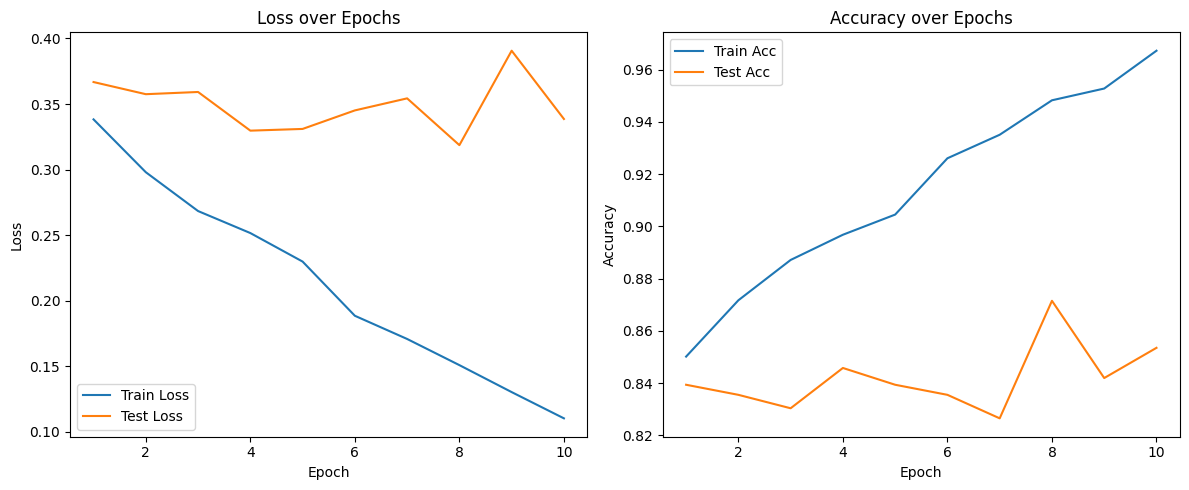

In [36]:
num_epochs = 10  # 你要训练多少轮

# 记录每个 epoch 的指标，用于画图
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # ========== 训练阶段 ==========
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for batch_idx, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        current_loss = loss.item()
        current_acc = correct / total
        # 在进度条上显示当前batch的Loss和Acc
        pbar.set_postfix({"loss": f"{current_loss:.4f}", "acc": f"{current_acc:.4f}"})
    
    # 计算该 epoch 的平均训练损失与准确率
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # 打印本 epoch 训练结果
    print(f"\nEpoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # ========== 测试阶段 ==========
    model.eval()
    test_running_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for imgs_test, labels_test in test_loader:
            imgs_test = imgs_test.to(device)
            labels_test = labels_test.to(device)
            outputs_test = model(imgs_test)
            loss_test = criterion(outputs_test, labels_test)

            test_running_loss += loss_test.item() * imgs_test.size(0)

            _, predicted_test = torch.max(outputs_test, 1)
            correct_test += (predicted_test == labels_test).sum().item()
            total_test += labels_test.size(0)

    # 计算测试集平均损失、准确率
    test_epoch_loss = test_running_loss / total_test if total_test > 0 else 0
    test_epoch_acc = correct_test / total_test if total_test > 0 else 0
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc)

    # 打印本 epoch 测试结果
    print(f"               Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}\n")


# ========== 3. 训练完成后画图 ==========
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# ---- (1) 损失曲线 ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ---- (2) 准确率曲线 ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, test_accuracies, label='Test Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*56*56, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
# 在卷积到全连接的中间插入一个 Dropout, p=0.5表示50%的神经元被drop*****
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(32*56*56, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (B,16,112,112)
        x = self.pool(torch.relu(self.conv2(x)))  # (B,32,56,56)
        x = x.view(x.size(0), -1)                 # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(in_channels=3, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 3

Epoch 1/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 1/10 - Train Loss: 0.4788, Train Acc: 0.7777
               Test Loss: 0.4403, Test Acc: 0.7821



Epoch 2/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 2/10 - Train Loss: 0.4448, Train Acc: 0.7829
               Test Loss: 0.4368, Test Acc: 0.7950



Epoch 3/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 3/10 - Train Loss: 0.4399, Train Acc: 0.7862
               Test Loss: 0.4223, Test Acc: 0.7824



Epoch 4/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 4/10 - Train Loss: 0.4278, Train Acc: 0.7883
               Test Loss: 0.4246, Test Acc: 0.7852



Epoch 5/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 5/10 - Train Loss: 0.4215, Train Acc: 0.7950
               Test Loss: 0.4161, Test Acc: 0.8240



Epoch 6/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 6/10 - Train Loss: 0.4147, Train Acc: 0.8058
               Test Loss: 0.3999, Test Acc: 0.8004



Epoch 7/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 7/10 - Train Loss: 0.4082, Train Acc: 0.8065
               Test Loss: 0.4022, Test Acc: 0.8209



Epoch 8/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 8/10 - Train Loss: 0.4079, Train Acc: 0.8153
               Test Loss: 0.3964, Test Acc: 0.8215



Epoch 9/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 9/10 - Train Loss: 0.4087, Train Acc: 0.8114
               Test Loss: 0.4042, Test Acc: 0.8269



Epoch 10/10:   0%|          | 0/243 [00:00<?, ?batch/s]


Epoch 10/10 - Train Loss: 0.4030, Train Acc: 0.8184
               Test Loss: 0.3923, Test Acc: 0.8099



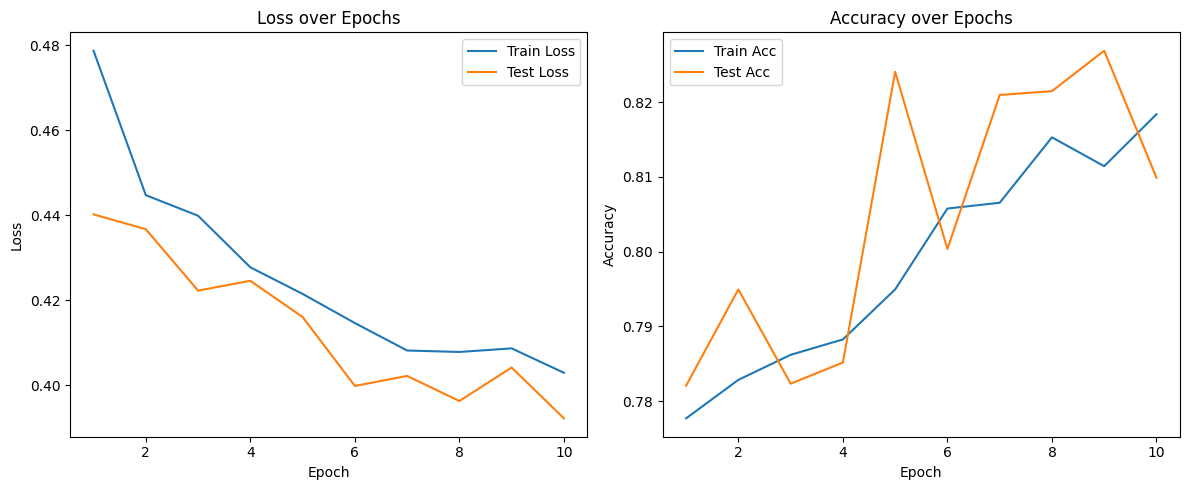

In [40]:
num_epochs = 10  # 你要训练多少轮

# 记录每个 epoch 的指标，用于画图
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # ========== 训练阶段 ==========
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for batch_idx, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        current_loss = loss.item()
        current_acc = correct / total
        # 在进度条上显示当前batch的Loss和Acc
        pbar.set_postfix({"loss": f"{current_loss:.4f}", "acc": f"{current_acc:.4f}"})
    
    # 计算该 epoch 的平均训练损失与准确率
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # 打印本 epoch 训练结果
    print(f"\nEpoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # ========== 测试阶段 ==========
    model.eval()
    test_running_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for imgs_test, labels_test in test_loader:
            imgs_test = imgs_test.to(device)
            labels_test = labels_test.to(device)
            outputs_test = model(imgs_test)
            loss_test = criterion(outputs_test, labels_test)

            test_running_loss += loss_test.item() * imgs_test.size(0)

            _, predicted_test = torch.max(outputs_test, 1)
            correct_test += (predicted_test == labels_test).sum().item()
            total_test += labels_test.size(0)

    # 计算测试集平均损失、准确率
    test_epoch_loss = test_running_loss / total_test if total_test > 0 else 0
    test_epoch_acc = correct_test / total_test if total_test > 0 else 0
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc)

    # 打印本 epoch 测试结果
    print(f"               Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}\n")


# ========== 3. 训练完成后画图 ==========
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# ---- (1) 损失曲线 ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ---- (2) 准确率曲线 ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, test_accuracies, label='Test Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()